In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import cv2
import numpy as np
import time
from PIL import Image

import torch

import sys
sys.path.append('./yolov3-text/')
import model


import sys
sys.path.append('./yolov3-com/')
from models import *
from utils.datasets import *
from utils.utils import *

Using TensorFlow backend.


In [2]:
#text 文本检测需要函数
def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    w,h = img.size
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.size[::-1]
        
    else:
        imgW,imgH = img.size

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = model.xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = model.box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,5)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,5)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,5)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,5)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp)

In [3]:
#coco检测
def detect(
        cfg='yolov3-com/cfg/yolov3.cfg',
        weights='yolov3-com/weights/yolov3.weights',
        image = '',
        img_size=416,
        conf_thres=0.3,
        nms_thres=0.45,
        save_txt=False
):

    # Initialize model
    model = Darknet(cfg, img_size)

    # Load weights
    if weights.endswith('.pt'):  # pytorch format
        if weights.endswith('yolov3.pt') and not os.path.exists(weights):
            if (platform == 'darwin') or (platform == 'linux'):
                os.system('wget https://storage.googleapis.com/ultralytics/yolov3.pt -O ' + weights)
        model.load_state_dict(torch.load(weights, map_location='cpu')['model'])
    else:  # darknet format
        _ = load_darknet_weights(model, weights)

    model.cuda().eval()

    
#   dataloader = LoadImages(images, img_size=img_size)
    # Padded resize
    im0 = image
    img, _, _, _ = letterbox(im0, height=img_size)
    # Normalize RGB
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
    img = np.ascontiguousarray(img, dtype=np.float32)  # uint8 to float32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0

    # Get classes and colors
    classes = load_classes(parse_data_cfg('yolov3-com/cfg/coco.data')['names'])
    colors = [[random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for _ in range(len(classes))]

    t = time.time()

    # Get detections
    img = torch.from_numpy(img).unsqueeze(0).cuda()
    if ONNX_EXPORT:
        torch.onnx.export(model, img, 'yolov3-com/weights/model.onnx', verbose=True)
        return
    pred = model(img)
    pred = pred[pred[:, :, 4] > conf_thres]  # remove boxes < threshold

    if len(pred) > 0:
        # Run NMS on predictions
        detections = non_max_suppression(pred.unsqueeze(0), conf_thres, nms_thres)[0]

        # Rescale boxes from 416 to true image size
        scale_coords(img_size, detections[:, :4], im0.shape).round()

        # Print results to screen
        unique_classes = detections[:, -1].cpu().unique()
        for c in unique_classes:
            n = (detections[:, -1].cpu() == c).sum()
            print('%g %ss' % (n, classes[int(c)]), end=', ')

#         # Draw bounding boxes and labels of detections
#         for x1, y1, x2, y2, conf, cls_conf, cls in detections:
# #             if save_txt:  # Write to file
# #                 with open(save_path + '.txt', 'a') as file:
# #                     file.write('%g %g %g %g %g %g\n' %
# #                                (x1, y1, x2, y2, cls, cls_conf * conf))

#             # Add bbox to the image
#             label = '%s %.2f' % (classes[int(cls)], conf)
#             plot_one_box([x1, y1, x2, y2], im0, label=label, color=colors[int(cls)])

        dt = time.time() - t
        print('Done. (%.3fs)' % dt)
        return detections

Detect take:1.4287245273590088s
2 persons, Done. (0.020s)
tensor([[3.97390e+01, 5.97393e+00, 3.54653e+02, 3.99887e+02, 9.89116e-01, 9.99999e-01, 0.00000e+00],
        [4.56504e+02, 2.21891e+02, 7.46667e+02, 3.98407e+02, 3.02441e-01, 4.42422e-01, 0.00000e+00]], device='cuda:0')


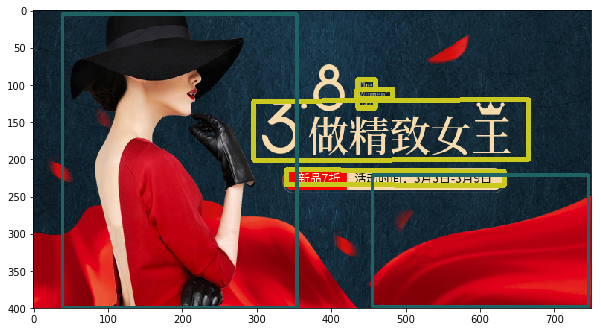

KeyboardInterrupt: 

In [7]:
#图像
pdir = "/home/datalab/ex_disk/work/shengdan/dataset/poster/allimg/"
ppath = [os.path.join(pdir,i) for i in os.listdir(pdir)]
for p in ppath:
    import requests as req
    from PIL import Image
    from io import BytesIO
    response = req.get('https://st-gdx.dancf.com/templets/85518/shots/20190306-153705-svGGr.png')
    img = Image.open(BytesIO(response.content)).convert('RGB')
#     p = '/home/datalab/ex_disk/work/shengdan/dataset/poster/allimg/26163.jpg'
#     img = Image.open(p).convert("RGB")
    w,h = img.size


    #检测文本
    timeTake = time.time()
    _,result,angle= model.model(img,
                                        detectAngle=False,##是否进行文字方向检测
                                        config=dict(MAX_HORIZONTAL_GAP=100,##字符之间的最大间隔，用于文本行的合并
                                        MIN_V_OVERLAPS=0.7,
                                        MIN_SIZE_SIM=0.7,
                                        TEXT_PROPOSALS_MIN_SCORE=0.1,
                                        TEXT_PROPOSALS_NMS_THRESH=0.3,
                                        TEXT_LINE_NMS_THRESH = 0.99,##文本行之间测iou值
                                        MIN_RATIO=1.0,
                                        LINE_MIN_SCORE=0.1,
                                        TEXT_PROPOSALS_WIDTH=0,
                                        MIN_NUM_PROPOSALS=0,                                               
                    ),
                                        leftAdjust=True,##对检测的文本行进行向左延伸
                                        rightAdjust=True,##对检测的文本行进行向右延伸
                                        alph=0.1,##对检测的文本行进行向右、左延伸的倍数
                                        ifadjustDegree=False
                                       )

    timeTake = time.time()-timeTake

    #画图
    text_img = plot_boxes(img,angle, result,color=(200,200,30))
    com_img = cv2.cvtColor(np.asarray(text_img),cv2.COLOR_RGB2BGR)

    with torch.no_grad():
        detections = detect(image=com_img)

        # Draw bounding boxes and labels of detections
        print(detections)
        if isinstance(detections,torch.Tensor):
            for x1, y1, x2, y2, conf, cls_conf, cls in detections:
                # Add bbox to the image

                plot_one_box([x1, y1, x2, y2], com_img, label='', color=(100,100,30))

    res_img = Image.fromarray(cv2.cvtColor(com_img,cv2.COLOR_BGR2RGB))
    plt.figure(figsize=(10,10))  
    plt.imshow(res_img)
    plt.show()